In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os
import json

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *
from worm_env import *

# Initial checks

In [169]:
cam.exit()

In [206]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [207]:
bgs = make_vec_bg(cam,task,[0,1],total_time=10)

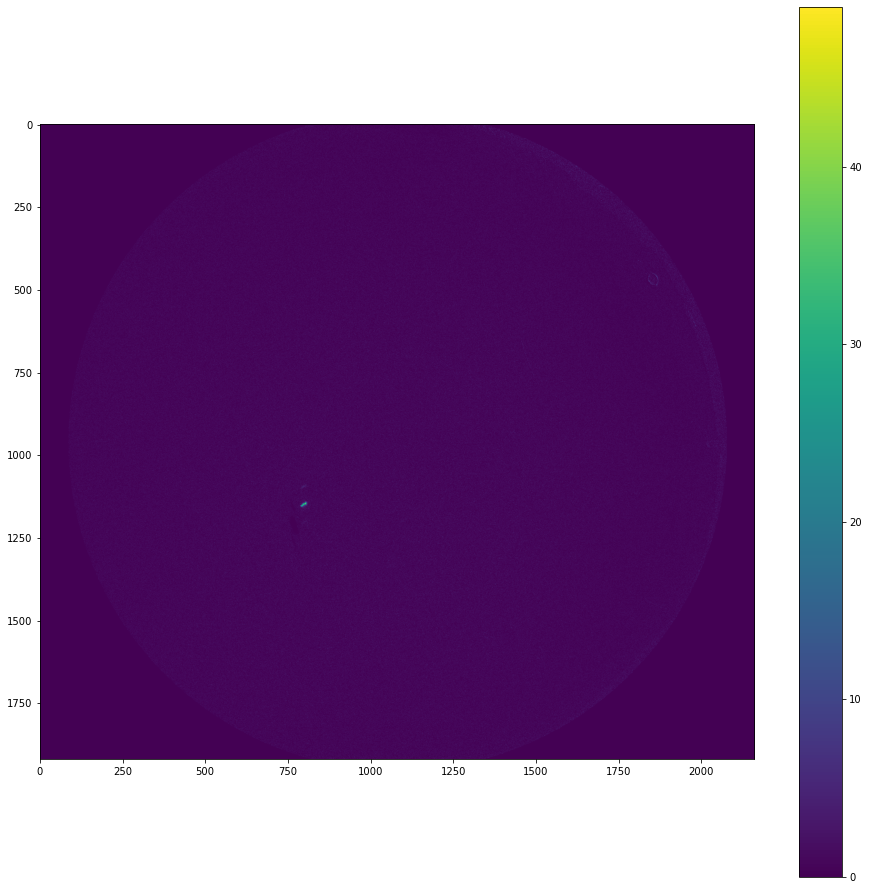

In [208]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([ 796.68055556, 1149.48611111]), 'img': array([[0, 0, 0, ..., 2, 2, 0],
       [0, 0, 0, ..., 1, 2, 1],
       [0, 0, 0, ..., 0, 2, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 2, ..., 1, 0, 1],
       [0, 0, 1, ..., 3, 2, 0]], dtype=uint8), 'scores': array([62313, 64917]), 'angs': array([ 90, 180]), 'endpts': array([[ 802,  788],
       [1143, 1154]]), 'body': 30}]


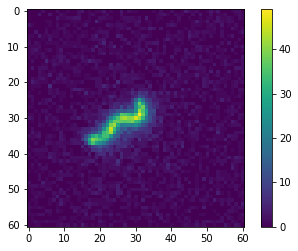

In [209]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

In [210]:
track,angs,lights = if_stmt_angle(0,cam,task,bgs,templates,bodies,total_time=30)

Finding orientation
elapsed 2

1
	 840.35 -1132.23
	body 30 head 0 light 1
2
	 845.86 -1132.64
	body 330 head 0 light 1
3
	 849.36 -1133.35
	body 330 head 0 light 1
4
	 852.56 -1133.73
	body 330 head 90 light 1
6
	 857.29 -1133.2
	body 30 head 330 light 1
7
	 861.36 -1132.29
	body 30 head 60 light 0
8
	 865.79 -1131.09
	body 30 head 270 light 1
10
	 869.63 -1131.83
	body 330 head 0 light 1
11
	 873.47 -1132.32
	body 330 head 0 light 1
12
	 876.69 -1133.43
	body 330 head 0 light 1
14
	 880.62 -1133.97
	body 330 head 90 light 1
15
	 885.11 -1133.07
	body 30 head 0 light 1
16
	 888.22 -1131.69
	body 30 head 30 light 0
18
	 892.17 -1130.52
	body 30 head 270 light 1
19
	 896.03 -1130.65
	body 300 head 0 light 1
20
	 899.43 -1131.6
	body 330 head 300 light 0
22
	 902.12 -1132.54
	body 330 head 60 light 1
23
	 905.8 -1132.97
	body 330 head 0 light 1
Didn't find right worm
24
	 910.5 -1132.29
	body 30 head 60 light 0
26
	 915.77 -1130.89
	body 30 head 300 light 1
27
	 918.34 -1130.71
	body 30 

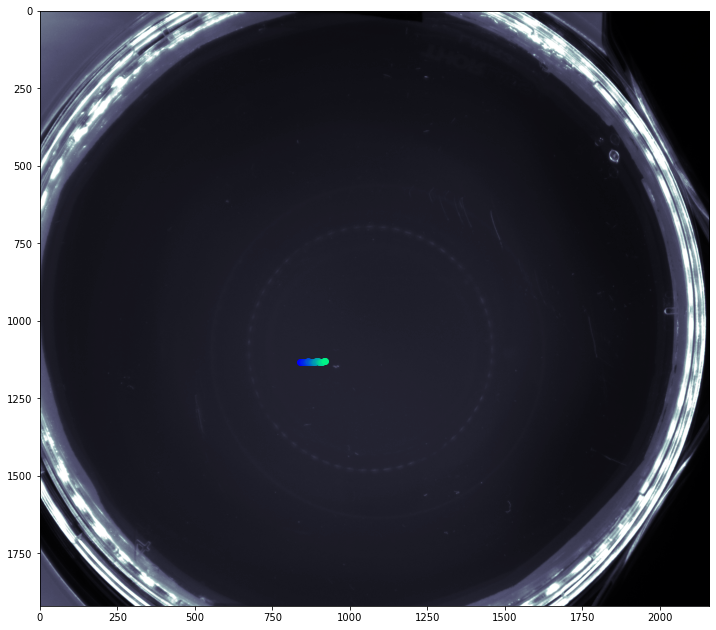

In [211]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

In [212]:
cam.exit()

# Benchmarking. 
This includes deterministic policy and simple averaging.

## Random actions
#### Program flow:
* Initializes environment.
* Collects background and sets target angle
* Runs 8 episodes for 5 minutes (300 s) each:
    * While episode is going:
        * Randomly picks action
        * Takes one step
        * Adds results to a trajectory dictionary
    * Prints number of steps taken during episode
    * Saves entire trajectory to .json file as dictionary
* Closes environment.

In [9]:
# Save track, total reward history, observations, endpoints, images, action history
fbase = 'Data/Random_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 8

curr_ep = 0
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        action = env.action_space.sample()
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
    print("Episode finished after {} timesteps".format(int(trajectory['t'][-2])))
    np.savez(fname, **trajectory)
    
env.close()

Episode finished after 299 timesteps
Episode finished after 299 timesteps


C:\Users\ccli3\miniconda3\envs\r911\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Episode finished after 299 timesteps
Episode finished after 299 timesteps
Episode finished after 299 timesteps
Episode finished after 299 timesteps
Episode finished after 299 timesteps
Episode finished after 299 timesteps


## Deterministic policy
Same flow as random action above but picks actions according to known AIY policy.

In [2]:
def det_policy(obs):
    # Returns 0 if obs is nans.
    # Otherwise, returns the known deterministic policy.
    if np.isnan(obs[0]):
        return 0
    body_dir,head_body = obs
    if body_dir*head_body < 0:
        action = 1
    elif body_dir == 0:
        if head_body == 0:
            action = 1
        else:
            action = 0
    else:
        action = 0
    return action

In [6]:
env.close()

In [7]:
fbase = 'Data/Known_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 8

curr_ep = 3
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Chooses action for next step
        action = det_policy(obs)
        
    print("Episode finished after {} timesteps".format(int(trajectory['t'][-2])))
    np.savez(fname, **trajectory)
    
env.close()

Episode finished after 0 timesteps
Episode finished after 0 timesteps
Episode finished after 0 timesteps
Episode finished after 0 timesteps


C:\Users\ccli3\miniconda3\envs\r911\lib\site-packages\nidaqmx\task.py:102: ResourceWarning: Task of name "_unnamedTask<0>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


Episode finished after 0 timesteps


# Q tables with TD learning

Keeps a table of Q values that are updated with TD learning. 
Hyperparameter tuning necessary (alpha, gamma, epsilon).

In [138]:
class QTab_Agent():
    """
    General Q table agent.
    """
    def __init__(self,SA_discrete=(12,12,2),alpha=0.01,gamma=0.5,eps=0.1):
        # SA_discrete is (state0, state1, action) sizes
        # alpha is learning step size
        # gamma is discount factor
        # eps is the proportion of time random actions are selected
        
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.qtab = np.random.normal(scale=0.1,size=SA_discrete)
        self.obs_count = np.zeros(SA_discrete)
        
    def load(self,fname):
        chkpt = np.load(fname,allow_pickle=True)
        self.alpha = chkpt['alpha']
        self.gamma = chkpt['gamma']
        self.eps = chkpt['eps']
        
        self.qtab = chkpt['qtab']
        self.obs_count = chkpt['count']
        
    def learn(self, obs, obs_next, act, reward, DEG_STEP=30):
        # Takes obs_t, act_t, r_{t+1} and updates table if all values are valid.
        # DEG_STEP is the angle increment for discretizing states
        
        # Q table update step:
        # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
        
        if np.isnan(obs[0]) or np.isnan(obs_next[0]):
            return
        
        i_obs = self.obs2ind(obs)
        i_obs_next = self.obs2ind(obs_next)
        
        # Update rule and update count
        self.qtab[i_obs[0],i_obs[1],act] = self.qtab[i_obs[0],i_obs[1],act] + \
            self.alpha*(reward+self.gamma*np.max(self.qtab[i_obs_next[0],i_obs_next[1],:])
                  - self.qtab[i_obs[0],i_obs[1],act])
        self.obs_count[i_obs[0],i_obs[1],act] += 1
        
    def sample(self, obs):
        # Finds the best action for a given state.
        # eps of the time, returns a random choice for exploration.
        if np.isnan(obs[0]):
            return 0
        if np.random.uniform() < self.eps:
            return np.random.randint(0,2)
        i_obs = self.obs2ind(obs) 
        return np.argmax(self.qtab[i_obs[0],i_obs[1],:])
        
    def obs2ind(self,obs):
        # Maps [-180,180] to [0,11].
        # Must take valid obs (no nans)
        i_obs = np.zeros(2)
        for i in range(2):
            if obs[i]==180:
                i_obs[i] = -180
            i_obs[i] = int((obs[i]+180)/30)
        return i_obs.astype(int)
    
    def save(self,fname):
        # Saves agent as npz file with keys 'qtab' and 'count'.
        agent_dict = {
            'qtab':self.qtab,
            'count':self.obs_count,
            'eps':self.eps,
            'alpha':self.alpha,
            'gamma':self.gamma
        }
        np.savez(fname,**agent_dict)

C:\Users\ccli3\miniconda3\envs\r911\lib\site-packages\nidaqmx\task.py:102: ResourceWarning: Task of name "_unnamedTask<12>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


In [91]:
env.close()

In [ ]:
fbase = 'Data/Qtab_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 8

curr_ep = 0
WORM_NUMBER = 5

agent = QTab_Agent(alpha=0.01,gamma=0.5,eps=0.1)
agent.load('Data/Qtab_i0_39_agent.npz')

for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    old_obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             np.around(info['loc'],1),round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Trains agent and chooses action for next step
        agent.learn(old_obs,obs,action,r)
        action = agent.sample(obs)
        old_obs = obs
        
    print("Episode finished after {} timesteps".format(int(trajectory['t'][-2])))
    np.savez(fname, **trajectory)
    agent.save(fname[:-4]+'_agent.npz')
    
env.close()

Episode finished after 299 timesteps


In [195]:
env.close()